# PCR Implementation

In [361]:
from sklearn.base import BaseEstimator
import scipy.linalg

class PCR(BaseEstimator):
    
    def __init__(self, n_components=1):
        self.n_components = n_components
    
    def fit(self, X, y):
        tr = TruncatedSVD(n_components=self.n_components).fit(X)
        X = tr.transform(X)
        X = tr.inverse_transform(X)
        self.coef_ = scipy.linalg.pinv(X.T @ X) @ X.T @ y
        return self

    def predict(self, X):
        return X @ self.coef_

# Simple: Prediction from Noisy Low-Rank Measurements

In [378]:
import numpy as np
n = 1000
T = 5000
u = np.random.normal(0, 1, size=(n, 1))
v = np.random.normal(0, 1, size=(T, 1))
W = u @ v.T
Z = W + np.random.normal(0, .7, size=(n, T))

In [379]:
X = Z[1:, :-10].T
y = Z[0, :-10]
Xtest = Z[1:, -10:].T
ytest = Z[0, -10:]
gtest = W[0, -10:]

In [380]:
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

cross_val_score(PCR(), X, y, scoring='r2')

array([0.78629512, 0.77022236, 0.75434644, 0.78337691, 0.77335559])

In [381]:
from sklearn.metrics import r2_score
est = PCR().fit(X, y)

In [382]:
pred_test = est.predict(Xtest)

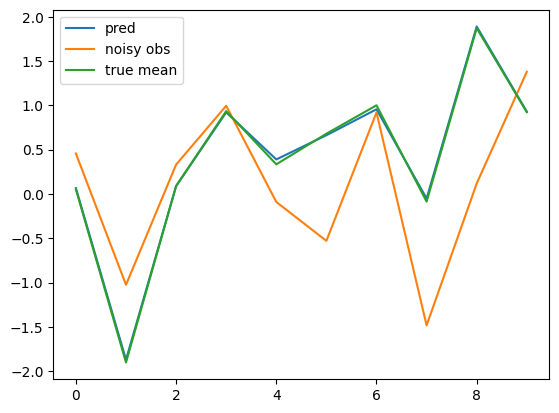

In [384]:
plt.plot(pred_test, label='pred')
plt.plot(ytest, label='noisy obs')
plt.plot(gtest, label='true mean')
plt.legend()
plt.show()

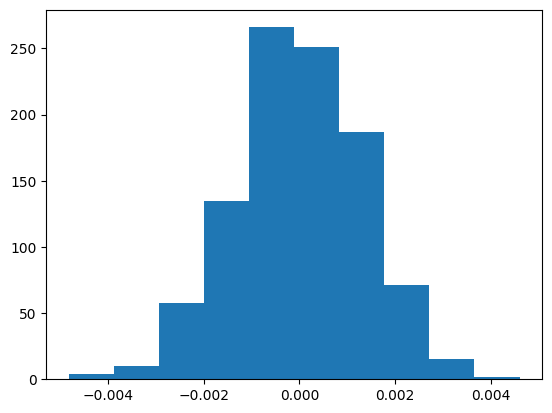

In [385]:
import matplotlib.pyplot as plt
plt.hist(est.coef_)
plt.show()

# Synthetic Controls with Staggered Rollout

In [323]:
import numpy as np
n = 1000 # n units
T = 5000 # n overall time periods
K = 2 # n actions (for now has to be true)
u = np.random.normal(0, 1, size=(n, 1)) # unit latent factors
v = np.random.normal(0, 1, size=(K, T, 1)) # (action, time) latent factors
W = np.einsum('ij,jtk->itk', u, v.T) # true mean potential outcomes for each unit and period
Z = W + np.random.normal(0, 1, size=(n, T, K)) # random potential outcomes for each unit and period

In [330]:
T0 = T - 10 # pre-treatment period length
t0 = np.random.choice(np.arange(T0, T + 1), size=n, replace=True) # choose random rollout time after T0
time = np.tile(np.arange(T), (n, 1)) # helper matrix
D = (time >= np.tile(t0.reshape(-1, 1), (1, T))) * 1 # set treatment to 1 after rollout

In [354]:
Zobs = Z[:, :, 0] * (1 - D) + Z[:, :, 1] * D # observed noisy outcomes
Wobs = W[:, :, 0] * (1 - D) + W[:, :, 1] * D # observed true mean outcomes

In [332]:
# we only care about the first unit and we use the rest to predict
X = Zobs[1:, :T0].T
y = Zobs[0, :T0]
Xtest = Zobs[1:, T0:].T
ytest = Zobs[0, T0:]

In [333]:
t0[0] - T0

6

In [335]:
pred_test = np.zeros(T)
for t in np.arange(T0, T):
    donors = (D[1:, t] == 0) # find units that are un-treated in this post-treatment period
    est = PCR().fit(X[:, donors], y) # find coefficients to donor units using PCR
    pred_test[t] = est.predict(Xtest[t - T0, donors]) # predict the outcome for the target unit for this period

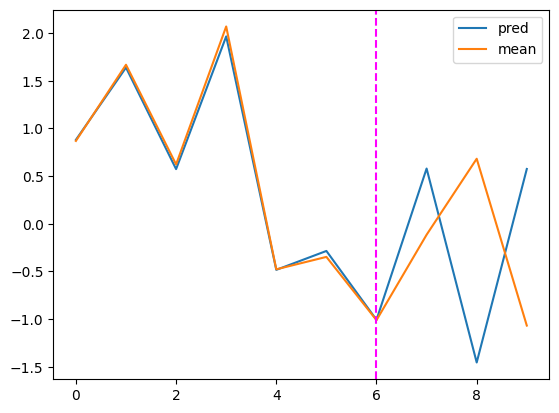

In [353]:
t1 = T0
t2 = T
plt.plot(pred_test[t1:t2], label='pred')
# plt.plot(ytest, label='observed')
plt.plot(Wobs[0, t1:t2], label='mean')
plt.axvline(t0[0] - T0, color='magenta', linestyle='--')
plt.legend()
plt.show()